# Control of Aggregate Equilibrium Size

Reference https://ac-els-cdn-com.ezproxy.neu.edu/S092777571300558X/1-s2.0-S092777571300558X-main.pdf?_tid=a68d75de-2d4b-4e84-858f-c3866c0dcf14&acdnat=1542312142_f822cc2a074bc4ea24c4df9fcae90672 for the initial part of the project.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate as integrate
import math

In [2]:
L = np.linspace(0,5,101)
size_step = np.diff(L)

In [3]:
def initial(L):
    #eqn taken from reference 39, eqn 20, v0 assumed to be 1 m^-3, like in the paper
    density = np.exp(-L)
    return density

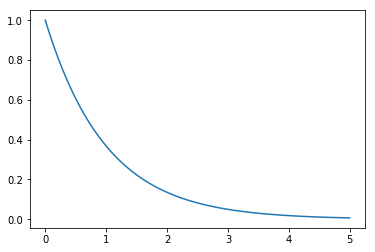

In [4]:
plt.plot(L, initial(L))

In [5]:
avg_size = sum(initial(L)/len(initial(L)))
avg_size
#seems reasonable? (in um)

0.2017103807225175

**Assume there is no growth or brakage and only aggregation for now. (Eq. 2)**

$$\frac{\Delta n}{\Delta t} = B - D$$

**To calculate the aggregation frequency, use the following equation. (Eq. 3)**

$$\beta_{j,k} = \frac{2k_BT}{3{\mu}W_{j,k}}(r_j+r_k)(\frac{1}{r_j}+\frac{1}{r_k}) $$

Where the stability ratio $$ W_{j,k} = (r_j+r_k)\int_{r_j+r_k}^{\infty} \frac{exp(V_T/(k_bT))}{R^2} dR $$

$$ V_T = V_A + V_E $$

$$ V_A = -\frac{A}{6}(\frac{2r_1r_2}{R^2-(r_1+r_2)^2}+\frac{2r_1r_2}{R^2(r_1-r_2)^2}+\frac{R^2-(r_1+r_2)^2}{R^2-(r_1-r_2)^2}) $$

$$ V_E = 64\pi\epsilon_r\epsilon_0(\frac{k_BT}{z_ce})^2 tanh(\frac{z_ce\psi_{01}}{4k_BT})tanh(\frac{z_ce\psi_{02}}{4k_BT})(\frac{r_1r_2}{r_1+r_2})exp(-\kappa(R-r_1-r_2)) $$

The value of the debye-huckel parameter comes from http://faculty.washington.edu/stn/ess_312/notes/Debye-Huckel.pdf.

$$ \kappa = \sqrt{\frac{8\pi^2N\rho I}{1000\epsilon k T}} $$

Where the ionic strength is the weighted sum of valence of the ions in solution. $$ I = \frac{1}{2}\sum_j m_j z_j^2 $$

But this should simplify because we only have one ion in solution and we can solve for the molality and we already have the valence of the counterion.

In [6]:
#some constants, from paper
kB = 1.3806 * 10**(-23) #m^2 * kg / (s^2 * K)
A = 3.08 * 10**(-20) #J
psi = 59/1000 #mV #surface potential (UNITS???)
T = 300 #K, im assuming this cuz its not given
mu = 0.00086 #N * s / m^2, from engineering toolbox cuz its not given
#R = ??? #center to center distance btwn particles
er = 80.4 #dielectric constant of solvent (water)
e0 = 8.85*10**-12 #dielectric constant of vacuum (F/m) eng'g toolbox
zc = 1 #valence of potassium counterion
e = 1.6021766*10**-19 # elementary charge (C)
N = 6.022*10**23 #Avogadros Number
rho = 1*10**3 #kg/m^3 
r1=1
r2=2

In [7]:
#solve for the Debye-Huckel Parameter
#it depends on the molality of salt ions in solution

#ONLY VALID AT 0.29 M SALT

M = 0.29 #mol/L
m = M*1000/(rho)
I = (m*zc**2)/2
kappa = (8*(math.pi**2)*N*rho*I/(1000*er*kB*T))**.5
print("The value for the Debye-Huckel Parameter is {} ... I think..".format(kappa))

The value for the Debye-Huckel Parameter is 4.5501598779759206e+21 ... I think..


In [8]:
#attractive potential
def Va(R, r1, r2):
    Va =-A/6*(2*r1*r2/(R**2-(r1+r2)**2)+2*r1*r2/(R**2*(r1-r2)**2)+(R**2-(r1 + r2)**2)/(R**2-(r1-r2)**2))
    return Va

#repulsive potential
def Ve(R, r1,r2):
    Ve=64*math.pi*er*e0*(kB*T/(zc*e))**2*(np.tanh(zc*e*psi/(4 * kB * T)))**2*r1*r2/(r1+r2)*np.exp(-kappa*(R-r1-r2))
    return Ve

#total potential
def VT(R, r1,r2):
    VT = Ve(R, r1,r2) + Va(R,r1,r2)
    return VT

#integrand to solve for the stability ratio
def W(R, r1,r2):
    W = (r1+r2)*np.exp(VT(R,r1,r2)/(kB*T))/(R^2)
    return W

#aggregation frequency / growth kernel
def Beta(L, r1, r2):
    #eqn 3 (Brownian aggregation), 4 (aggregation efficiency),
    # and 5 and 6 (interaction potential components)
    # the equations use both j,k and 1,2 should we just use one consistently?
    
    
    #solve for the stability ratio
    #we have to integrate over the range in possible center-to-center distances
    Wjk = (r1 + r2) * integrate.quad(W, r1+r2, 1000)
    
    # in eqn theres two tanh for the two colliding paticles but if theyre the same they have the same surface potential
    #solve for the aggregation frequency
    beta = 2 * kB * T / (3 * mu * Wjk) * (r1 + r2) * (1/r1 + 1/r2)
    return beta


In [9]:
beta_matrix = np.zeros((len(L),len(L)))
for i,r1 in enumerate(L):
    for j,r2 in enumerate(L):
        beta_matrix[i,j] = Beta(L, r1, r2)
print(beta_matrix.shape)
beta_matrix

TypeError: W() missing 2 required positional arguments: 'r1' and 'r2'

In [ ]:
#W() missing 2 required positional arguments: 'r1' and 'r2' unsure whats happening here.
#putting R last in W causes the issue to be only with R

s=Va(1, r1, r2)
s
# i think this means the number is too small- A?

In [ ]:
u=Ve(1, r1, r2)
u
#same issue, kappa?